In [1]:
#Importing necessary Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import precision_score,recall_score,auc
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor,StackingCVRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data=pd.read_csv('train_values.csv')
test_data=pd.read_csv('test_values.csv')
train_y=pd.read_csv('train_labels.csv')
test_y=pd.read_csv('test_labels.csv')

In [4]:
print('Training data shape:',train_data.shape)
print('Test data shape:',test_data.shape)

Training data shape: (609674, 42)
Test data shape: (152419, 42)


# Data Prep For Models

In [5]:
train_data.damage_grade=train_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})
test_data.damage_grade=test_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})

In [6]:
train=train_data

In [8]:
train_high=train[train.damage_grade=='High']
train_medium=train[train.damage_grade=='Medium']
train_low=train[train.damage_grade=='Low']


In [9]:
train_high=train_high.sample(100000)
train_medium=train_medium.sample(100000)
train_low=train_low.sample(100000)

In [10]:
train = pd.concat([train_high, train_medium,train_low], ignore_index=True, sort =False)
train=train.sample(frac=1)
train.head(5)

,building_id,geo1,geo2,geo3,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
6339,366701000571,36,3603,360302,1,0,25,500,10,0,...,0,0,0,0,0,0,0,0,0,0
129065,203402001911,20,2006,200605,2,2,7,480,18,18,...,0,0,0,0,0,1,0,0,0,0
179728,205405000711,20,2009,200909,2,2,5,550,30,30,...,0,0,0,0,0,0,0,0,0,0
274038,366301000201,36,3608,360802,3,3,42,394,18,18,...,0,0,0,0,0,0,0,0,0,0
203237,312009030371,31,3104,310409,1,1,1,370,12,12,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train=train.sample(300000)

# Train test validation split

In [12]:
y_train=train.damage_grade
train=train.drop('damage_grade',axis=1)

In [13]:
y_test=test_data.damage_grade
x_test=test_data.drop('damage_grade',axis=1)

In [14]:
#Cross validation data
x_train,x_cv,y_train,y_cv=train_test_split(train,y_train,stratify=y_train,test_size=0.3)

In [15]:
print('Data in Train dataset:',len(x_train))
print('Data in Test dataset:',len(x_test))
print('Data in CV dataset:',len(x_cv))

Data in Train dataset: 210000
Data in Test dataset: 152419
Data in CV dataset: 90000


In [16]:
# utility function to preprocess data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_num_data(train_data,cv_data,test_data):
    std=Normalizer()
    std.fit(train_data)
    transformed_input=std.transform(train_data)
    transformed_cv=std.transform(cv_data)
    transformed_test=std.transform(test_data)
    return transformed_input,transformed_cv,transformed_test
def preprocess_cat_data(train_data,cv_data,test_data):
    std=LabelEncoder()
    for col in train_data.columns:
        col_list_train=list(map(str,train_data[col].values))
        #print(col_list_train)
        col_list_cv=list(map(str,cv_data[col].values))
        col_list_test=list(map(str,test_data[col].values))
        std.fit(col_list_train)
        col_list_train=std.transform(col_list_train)
        col_list_test=std.transform(col_list_test)
        col_list_cv=std.transform(col_list_cv)
        train_data[col]=col_list_train
        test_data[col]=col_list_test
        cv_data[col]=col_list_cv
    return train_data,cv_data,test_data

In [17]:
num_data=['geo1', 'geo2', 'geo3',
       'count_floors_pre_eq','count_floors_post_eq', 'age_building','plinth_area_sq_ft','count_families',
         'height_ft_pre_eq', 'height_ft_post_eq']
cat_data=['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position','legal_ownership_status',
       'plan_configuration'] 
bin_data=['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
        'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']


In [18]:
# filtering numerical data
num_train=x_train[num_data]
num_test=x_test[num_data]
num_cv=x_cv[num_data]
# filtering categorical data
cat_train=x_train[cat_data]
cat_test=x_test[cat_data]
cat_cv=x_cv[cat_data]
# filtering binary data
bin_train=x_train[bin_data]
bin_test=x_test[bin_data]
bin_cv=x_cv[bin_data]


In [19]:
num_train,num_cv,num_test=preprocess_num_data(num_train,num_cv,num_test)
cat_train,cat_cv,cat_test=preprocess_cat_data(cat_train,cat_cv,cat_test)
bin_train,bin_cv,bin_test=preprocess_cat_data(bin_train,bin_cv,bin_test)

In [37]:
num_train.shape

(210000, 10)

In [21]:
!pip3 install scipy

In [38]:
from scipy.sparse import hstack
train_data_final=np.hstack((num_train,cat_train,bin_train))#.tocsr()
test_data_final=np.hstack((num_test,cat_test,bin_test))
cv_data_final=np.hstack((num_cv,cat_cv,bin_cv))

In [36]:
train_data_final.shape

(210000, 40)

In [39]:
# shape of final data matrixes
print(train_data_final.shape)
print(test_data_final.shape)
print(cv_data_final.shape)

(210000, 40)
(152419, 40)
(90000, 40)


In [40]:
#function to plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [41]:
# function to run any model
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    # calculate overall accuracty of the model
    print('---------Performance Score--------------')
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    precision=precision_score(y_true=y_test, y_pred=y_pred,average='micro')
    recall=recall_score(y_true=y_test, y_pred=y_pred,average='micro')
    micro_f1=f1_score(y_true=y_test, y_pred=y_pred,average='micro')
    print('\n Micro F1:{}'.format(micro_f1))
    print('\n Precision:{}'.format(precision))
    print('\n Recall:{}'.format(recall))
    print('\n Accuracy:{}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results,model
    
    

In [42]:
def predict_test_f1(model,x_test,y_test):
    y_pred=model.predict(x_test)
    micro_f1=f1_score(y_true=y_test, y_pred=y_pred,average='micro')
    print('\n Micro F1 Score of Test Data:{}'.format(micro_f1))

# Model Preparation

In [48]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle
import joblib 
import random

In [44]:
!pip3 install joblib

In [49]:
labels=['Low','Medium','High']

# Build line model with random prediction

In [50]:
y_pred_random=[]
for i in range(cv_data_final.shape[0]):
    y_pred_random.append(random.randint(1,3))
#y_pred_random=y_pred_random.map({1:'Low',2:'Medium',3:'High'})
y_cv_truth=y_cv.map({'Low':1,'Medium':2,'High':3})
score=f1_score(y_pred_random,y_cv_truth,average='micro')
print('F1 Score of random model on CV data is:',score)

F1 Score of random model on CV data is: 0.3339


# Logistic Regression

training the model..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/harshit/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/harshit/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Done 
 

training_time(HH:MM:SS.ms) - 0:01:22.612062


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.022977


---------Performance Score--------------

 Micro F1:0.5221777777777777

 Precision:0.5221777777777777

 Recall:0.5221777777777777

 Accuracy:0.5221777777777777

--------------------
| Confusion Matrix |

 [[22745  1867  5388]
 [ 8846 16731  4423]
 [17137  5343  7520]]


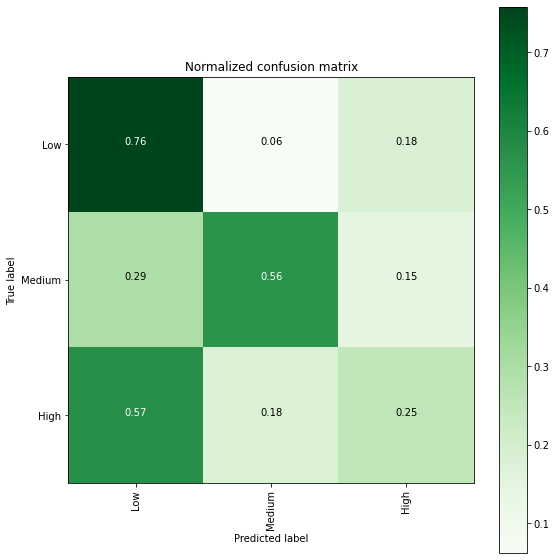

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

        High       0.47      0.76      0.58     30000
         Low       0.70      0.56      0.62     30000
      Medium       0.43      0.25      0.32     30000

    accuracy                           0.52     90000
   macro avg       0.53      0.52      0.51     90000
weighted avg       0.53      0.52      0.51     90000



In [51]:
# start Grid search
parameters = {'C':[0.01, 0.1, 1,5, 10], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression(class_weight='balanced')
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results,lr_model =  perform_model(log_reg_grid, train_data_final, y_train, cv_data_final, y_cv, class_labels=labels)

In [52]:
predict_test_f1(lr_model,test_data_final,y_test)


 Micro F1 Score of Test Data:0.6249483332130509


In [63]:
joblib.dump(lr_model,'log_reg_model.pkl')

['log_reg_model.pkl']

# Random Forest Classifier

training the model..
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:07:38.723306


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.553367


---------Performance Score--------------

 Micro F1:0.6745888888888889

 Precision:0.6745888888888889

 Recall:0.6745888888888889

 Accuracy:0.6745888888888889

--------------------
| Confusion Matrix |

 [[19102  1159  9739]
 [  247 18823 10930]
 [  811  6401 22788]]


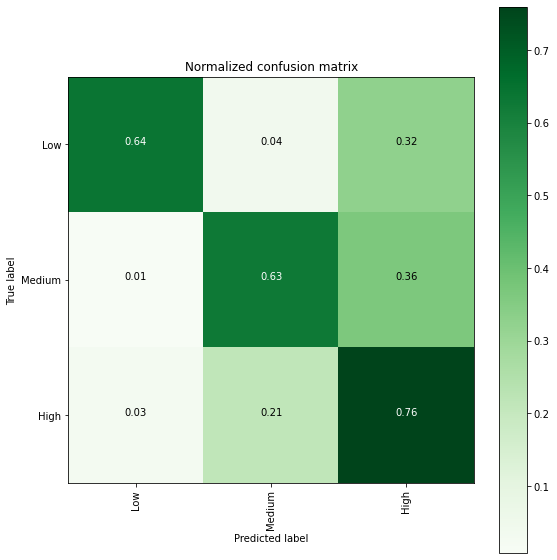

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

        High       0.95      0.64      0.76     30000
         Low       0.71      0.63      0.67     30000
      Medium       0.52      0.76      0.62     30000

    accuracy                           0.67     90000
   macro avg       0.73      0.67      0.68     90000
weighted avg       0.73      0.67      0.68     90000



In [53]:
from sklearn.ensemble import RandomForestClassifier
params = {'max_depth':[2,3,5,7],'n_estimators':[20,50,100,200]}
rf=RandomForestClassifier(class_weight='balanced')
grid=GridSearchCV(rf,param_grid=params,n_jobs=-1,verbose=1)
rf_res,rf_model=perform_model(grid,train_data_final, y_train,cv_data_final, y_cv, class_labels=labels)

In [54]:
predict_test_f1(rf_model,test_data_final,y_test)


 Micro F1 Score of Test Data:0.6564995177766552


In [55]:
joblib.dump(rf_model,'random_forest_model_65.pkl')

['random_forest_model_65.pkl']

# Multiclass LIGHTGBM

In [56]:
x_train_=x_train.drop('building_id',axis=1)
x_test_=x_test.drop('building_id',axis=1)
x_cv_=x_cv.drop('building_id',axis=1)
y_train_=y_train.map({'Low':0,'Medium':1,'High':2})
y_test_=y_test.map({'Low':0,'Medium':1,'High':2})
y_cv_=y_cv.map({'Low':0,'Medium':1,'High':2})

In [57]:
import lightgbm as lgbm
from sklearn.preprocessing import LabelBinarizer
#https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    cm = metrics.confusion_matrix(y_test_, lgb_prediction)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'micro')
    print("The Light GBM F1 is", lgb_F1)
    
def preprocess_cat_data_lgbm(train_data,cols):
    #print(cols)
    for col in train_data.columns:
        if(col in cols):
            std=LabelEncoder() 
            temp=list(train_data[col].values)
            res=std.fit_transform(temp)
            train_data[col]=res
    return train_data

def lgb_f1_score(y_pred,data):
    y_true = data.get_label().astype('int')
    #F1 score not improving in multiclass lgbm custom metric:https://github.com/Microsoft/LightGBM/issues/1483
    y_pred =y_pred.reshape((3,-1)).argmax(axis=0) 
    y_pred=np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred,average='micro'), True

def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'micro')
    print("The Light GBM F1 is", lgb_F1)

In [58]:
x_train_=preprocess_cat_data_lgbm(x_train,cols=cat_data)
x_cv_=preprocess_cat_data_lgbm(x_cv,cols=cat_data)
x_test_=preprocess_cat_data_lgbm(x_test,cols=cat_data)

learning rate=0.005

train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.005,
    'max_depth': 5,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],
                       num_boost_round=15000,
                       feval=lgb_f1_score,
                       verbose_eval=500,
                       early_stopping_rounds=300)

Parameter tuning:no of leaves

In [61]:
num_leaves=[10,20,30,40,50]
for n in num_leaves:
        train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
        test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
        cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)
        params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':3,
        'learning_rate': 0.05,
        'max_depth': 5,
        'num_leaves': n,
        'is_unbalanced':True,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.5}
        print('Num leaves:',n)
        clf=lgbm.train(params,train_data_lgbm,valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],num_boost_round=500,
                       feval=lgb_f1_score,verbose_eval=100,early_stopping_rounds=50)
        print('---------------------------------------------------')

Num leaves: 10
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 41
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.67681	train's f1: 0.691433	val's multi_logloss: 0.676545	val's f1: 0.690378
[200]	train's multi_logloss: 0.65889	train's f1: 0.697948	val's multi_logloss: 0.659618	val's f1: 0.697633
[300]	train's multi_logloss: 

Parameter tuning:max_depth

In [62]:
max_depth=[2,3,5,7]
for n in max_depth:
        train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
        test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
        cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)
        params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':3,
        'learning_rate': 0.05,
        'max_depth': n,
        'num_leaves': 40,
        'is_unbalanced':True,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.5}
        print('Max depth:',n)
        clf=lgbm.train(params,train_data_lgbm,valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],num_boost_round=5000,
                       feval=lgb_f1_score,verbose_eval=500,early_stopping_rounds=200)
        print('---------------------------------------------------')

Max depth: 2
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 41
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.668546	train's f1: 0.693276	val's multi_logloss: 0.667878	val's f1: 0.692256
[1000]	train's multi_logloss: 0.652049	train's f1: 0.702343	val's multi_logloss: 0.652319	val's f1: 0.702678
[1500]	train's multi_loglos

In [64]:
joblib.dump(clf,'lgbm_model_78.pkl')

['lgbm_model_78.pkl']

# Deep learning models

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM,Conv1D
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization,MaxPooling1D,Flatten
from keras.layers import GRU
import tensorflow as tf

2022-09-26 18:58:02.731312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-26 18:58:02.743532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [67]:
x_train_=np.expand_dims(x_train_,2)
x_cv_=np.expand_dims(x_cv_,2)
x_test_=np.expand_dims(x_test_,2)
y_train=np_utils.to_categorical(y_train_)
y_test=np_utils.to_categorical(y_test_)
y_cv=np_utils.to_categorical(y_cv_)


In [68]:
num_classes=3

In [69]:
def predict_(model,x_test,y_test):
    y_predict = np.asarray(model.predict(x_test))
    print(y_predict.shape)
    y_predict =y_predict.reshape((3,-1)).argmax(axis=0) 
    acc=accuracy_score(y_test, y_predict)
    score=f1_score(y_test, y_predict,average='micro')
    print("The micro F1 score of the model is", score)
    print("The accuracy score of the model is", acc)

In [70]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [71]:
def run_model(model,es_round=5,epoch=30,batch_size=64):
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1_m])
    cb=EarlyStopping(monitor='val_f1_m', min_delta=0, patience=es_round, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.fit(x_train_,y_train,batch_size=64,validation_data=(x_cv_,y_cv),callbacks=[cb],epochs=epoch,verbose=1)
    score=model.evaluate(x_test_,y_test)
    print('Evaluating Test Score..........')
    print("Test Loss:{} ".format(round(score[0],2)))
    print("Test Accuracy:{} %".format(int(round(score[1]*100))))
    print("Test F1 Score:{} ".format(score[2]))
    print('completed.')
    

In [72]:
batch_size=128
timesteps=x_train_.shape[1]
input_dimension=1
n_classes=3

In [73]:
model=Sequential()
model.add(Dense(64,input_shape=(timesteps,input_dimension)))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()


2022-09-26 19:05:35.093762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-26 19:05:35.093820: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-26 19:05:35.093867: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (harshit-HP-Notebook): /proc/driver/nvidia/version does not exist
2022-09-26 19:05:35.121372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 41, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 41, 3)             99        
                                                                 
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


# 1 LSTM ,3 dense layers

In [74]:
model=Sequential()
model.add(LSTM(32,input_shape=(timesteps,input_dimension)))
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,659
Trainable params: 6,659
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])

In [76]:
es=EarlyStopping(monitor='val_f1_m', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [78]:
history=model.fit(x_train_,y_train,batch_size=64,validation_data=(x_cv_,y_cv),callbacks=[es],epochs=15,verbose=1)

Epoch 1/15
3282/3282 [==============================] - 63s 19ms/step - loss: 0.7095 - accuracy: 0.6732 - f1_m: 0.6497 - val_loss: 0.7113 - val_accuracy: 0.6708 - val_f1_m: 0.6136
Epoch 2/15
3282/3282 [==============================] - 63s 19ms/step - loss: 0.7066 - accuracy: 0.6757 - f1_m: 0.6553 - val_loss: 0.6999 - val_accuracy: 0.6786 - val_f1_m: 0.6578
Epoch 3/15
3282/3282 [==============================] - 64s 19ms/step - loss: 0.7043 - accuracy: 0.6771 - f1_m: 0.6580 - val_loss: 0.7014 - val_accuracy: 0.6782 - val_f1_m: 0.6470
Epoch 4/15
3282/3282 [==============================] - 64s 19ms/step - loss: 0.7025 - accuracy: 0.6781 - f1_m: 0.6572 - val_loss: 0.7094 - val_accuracy: 0.6743 - val_f1_m: 0.6432
Epoch 5/15
3282/3282 [==============================] - 64s 19ms/step - loss: 0.7022 - accuracy: 0.6782 - f1_m: 0.6578 - val_loss: 0.7001 - val_accuracy: 0.6782 - val_f1_m: 0.6602
Epoch 6/15
3282/3282 [==============================] - 60s 18ms/step - loss: 0.7006 - accuracy: 0.6

# 1 LSTM,2 dense layers with dropout and BN

In [79]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dimension)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add((BatchNormalization()))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,915
Trainable params: 6,787
Non-trainable params: 128
__________________________________________________

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

In [81]:
run_model(model,es_round=3,batch_size=256)

Epoch 1/30
3282/3282 [==============================] - 67s 20ms/step - loss: 0.7713 - accuracy: 0.6316 - f1_m: 0.5614 - val_loss: 0.8580 - val_accuracy: 0.5895 - val_f1_m: 0.5650
Epoch 2/30
3282/3282 [==============================] - 68s 21ms/step - loss: 0.7254 - accuracy: 0.6658 - f1_m: 0.6207 - val_loss: 0.9355 - val_accuracy: 0.5368 - val_f1_m: 0.5352
Epoch 3/30
3282/3282 [==============================] - 64s 19ms/step - loss: 0.7195 - accuracy: 0.6698 - f1_m: 0.6295 - val_loss: 0.7222 - val_accuracy: 0.6580 - val_f1_m: 0.6492
Epoch 4/30
3282/3282 [==============================] - 65s 20ms/step - loss: 0.7147 - accuracy: 0.6724 - f1_m: 0.6363 - val_loss: 0.7285 - val_accuracy: 0.6586 - val_f1_m: 0.6261
Epoch 5/30
4764/4764 [==============================] - 27s 6ms/step - loss: 1.0426 - accuracy: 0.5668 - f1_m: 0.5797
Evaluating Test Score..........
Test Loss:1.04 
Test Accuracy:57 %
Test F1 Score:0.5796512365341187 
completed.


# Comparison

In [86]:
!pip3 install prettytable

In [87]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['model','Type','Micro average f1 score']
x.add_row(['1','random','0.33'])
x.add_row(['2','logistic regression','0.62'])
x.add_row(['3','Random Forest','0.65'])
x.add_row(['4','Light GBM','0.74'])
x.add_row(['5','LSTM','0.66'])
print(x)

+-------+---------------------+------------------------+
| model |         Type        | Micro average f1 score |
+-------+---------------------+------------------------+
|   1   |        random       |          0.33          |
|   2   | logistic regression |          0.62          |
|   3   |    Random Forest    |          0.65          |
|   4   |      Light GBM      |          0.74          |
|   5   |         LSTM        |          0.66          |
+-------+---------------------+------------------------+
